# Read Data

In [104]:
import h5py
import numpy as np
filepaths = ['Part1SubjectHB10.h5','Part2SubjectHB13.h5','Rat08-20130711_017.h5']

lfps = []
fss = []
for filepath in filepaths:
  print("\n" + filepath)

  f = h5py.File(filepath, 'r') # read data with h5 format
  fs = f.attrs['fs'][0] # get sampling frequency of LFP signal (Hz)
  fss.append(fs)
  print("Sampling rate: %.1f Hz" % (fs))

  states = [] # two states: NREM and WAKE
  for name, grp in f.items():
    states.append(name)
    print("State: %s" % (name))
    print("Segment IDs:")
    print(list(grp.keys()))

  # convert recording to numpy arrays
  # a dictionary stores the LFP recordings of both states, each
  # containing a list of numpy arrays of all segments
  lfp = {key: [] for key in states}
  for key in states:
    group = f[key] # h5 group of a state
    n = len(group) # number of segments
    for i in range(n):
      # convert data to numpy array and from int to float
      lfp[key].append(group[str(i+1)][()].astype(float))

  f.close()
  lfps.append(lfp)
#print(lfps)


Part1SubjectHB10.h5
Sampling rate: 1000.0 Hz
State: NREM
Segment IDs:
['1', '10', '11', '12', '13', '14', '15', '16', '17', '2', '3', '4', '5', '6', '7', '8', '9']
State: WAKE
Segment IDs:
['1', '10', '11', '12', '13', '14', '15', '16', '17', '18', '19', '2', '20', '21', '22', '23', '24', '25', '26', '27', '28', '29', '3', '30', '31', '32', '33', '34', '35', '36', '37', '38', '4', '5', '6', '7', '8', '9']

Part2SubjectHB13.h5
Sampling rate: 1000.0 Hz
State: NREM
Segment IDs:
['1', '10', '11', '12', '13', '14', '15', '16', '17', '18', '19', '2', '3', '4', '5', '6', '7', '8', '9']
State: WAKE
Segment IDs:
['1', '10', '11', '12', '13', '14', '15', '16', '17', '18', '19', '2', '20', '21', '22', '3', '4', '5', '6', '7', '8', '9']

Rat08-20130711_017.h5
Sampling rate: 1250.0 Hz
State: NREM
Segment IDs:
['1', '10', '11', '12', '13', '14', '15', '16', '17', '18', '19', '2', '20', '21', '22', '23', '24', '25', '26', '27', '28', '29', '3', '30', '31', '32', '33', '34', '35', '36', '37', '38', '

## Split Raw Data Into 5-Second Clips

In [105]:
clip_duration = 5  # seconds

subject1_nrem_clips = []
subject1_wake_clips = []
subject2_nrem_clips = []
subject2_wake_clips = []
subject3_nrem_clips = []
subject3_wake_clips = []
input_clips = [[subject1_nrem_clips,subject1_wake_clips],
               [subject2_nrem_clips,subject2_wake_clips],
               [subject3_nrem_clips,subject3_wake_clips]]

for subject_index, subject_data in enumerate(lfps):
    for state in subject_data:
        for segment_index, segment in enumerate(subject_data[state]):
            fs = fss[subject_index]
            clip_size = int(clip_duration * fs)
            num_clips = len(segment) // clip_size
            for i in range(num_clips):
                clip = segment[i * clip_size:(i + 1) * clip_size]
                # save the clip to an array holding clips of the same subject and state
                input_clips[subject_index][0 if state == 'NREM' else 1].append(clip)


# Extract Input Features For Each Clip

Each of the following features will be normalized:

- Mean
- Standard Deviation
- Skewness
- Kurtosis
- Band Statistics


In [106]:
from scipy.stats import skew, kurtosis
from scipy.signal import welch
import matplotlib.pyplot as plt

def compute_statistics(clip, fs):
  # compute PSD
  segment_length = max(1, int(len(clip) * 0.1))
  freqs, psd = welch(clip, fs=fs, nperseg=segment_length)

  return {
      'mean': float(np.mean(clip)),
      'std': float(np.std(clip)),
      'skew': float(skew(clip)),
      'kurt': float(kurtosis(clip)),
      'psd': psd.tolist(),
      'freqs': freqs.tolist()
  }

# clip_statistics[subject_index][state_index][clip_index]['statistic']
clip_statistics = []
for subject_index, subject_clips in enumerate(input_clips):
  subject_stats = []
  for state_index, state_clips in enumerate(subject_clips):
    state_stats = []
    for clip in state_clips:
      state_stats.append(compute_statistics(clip, fs=fss[subject_index]))
    subject_stats.append(state_stats)
  clip_statistics.append(subject_stats)



## Analyze PSD to Filter Oscillation Frequency Bands

Important Variables at this point are:
- input_clips [subject_index] [state_index] [clip_index]
- clip_statistics [subject_index] [state_index] [clip_index]

Variables can take on values in the following ranges:
- subject_index: 0, 1, 2
- state_index: 0, 1
- clip_index: 0, 1, 2, ..., num_of_clips - 1

### Begin By Averaging PSDs for Each State

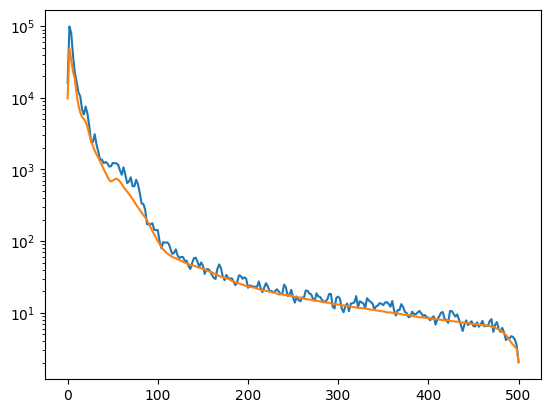

In [107]:
# combine PSDs of each state into one list
nrem_psds = []
wake_psds = []

for subject_stats in clip_statistics:
  for state_stats in subject_stats:
    for clip_stats in state_stats:
      if state_stats.index(clip_stats) == 0:
        # ensure all PSDs have the same length (required for np.mean)
        psd = clip_stats['psd']
        if len(nrem_psds) > 0 and len(psd) != len(nrem_psds[0]):
          # pad or truncate the PSD to match the first PSDs length
          if len(psd) > len(nrem_psds[0]):
            psd = psd[:len(nrem_psds[0])]
          else:
            psd = np.pad(psd, (0, len(nrem_psds[0]) - len(psd)), 'constant')
        nrem_psds.append(psd)
      else:
        # ensure all PSDs have the same length
        psd = clip_stats['psd']
        if len(wake_psds) > 0 and len(psd) != len(wake_psds[0]):
          # pad or truncate the PSD to match the first PSDs length
          if len(psd) > len(wake_psds[0]):
            psd = psd[:len(wake_psds[0])]
          else:
            psd = np.pad(psd, (0, len(wake_psds[0]) - len(psd)), 'constant')
        wake_psds.append(psd)

# average all PSDs in both lists
nrem_psd = np.mean(nrem_psds, axis=0)
wake_psd = np.mean(wake_psds, axis=0)

# plot the averaged PSDs
plt.semilogy(clip_statistics[0][0][0]['freqs'], nrem_psd, label='NREM')
plt.semilogy(clip_statistics[0][1][0]['freqs'], wake_psd, label='WAKE')

### Find the Peaks and Oscillation Bands

NREM Oscillation Bands: [(0.1, 12.0), (48.0, 64.0)]
WAKE Oscillation Bands: [(0.1, 12.0), (48.0, 64.0)]


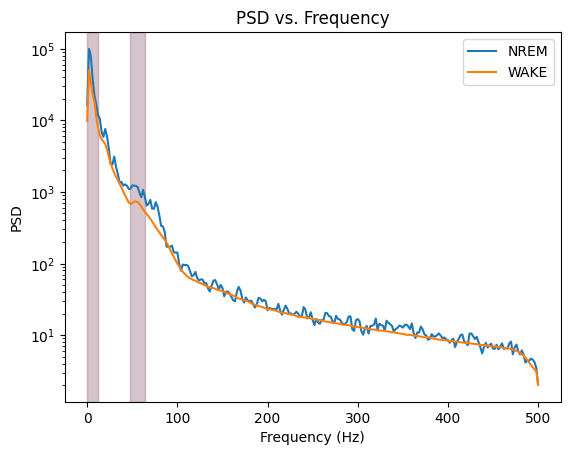

In [108]:
from scipy.signal import find_peaks

def detect_frequency_bands(freqs, psd, prominence=0.05, threshold=0.1, height=0, distance=10):
    peaks, _ = find_peaks(psd, prominence=prominence, threshold=threshold, height=height, distance=distance)  # Detect peaks
    bands = []
    for peak in peaks:
        center_freq = freqs[peak]
        band = (max(center_freq - 6, 0.1), center_freq + 10)  # Define ±4 Hz around peak
        bands.append(band)
    return bands

nrem_bands = detect_frequency_bands(clip_statistics[0][0][0]['freqs'], nrem_psd)
wake_bands = detect_frequency_bands(clip_statistics[0][1][0]['freqs'], wake_psd)

# narrow the bands down to 2 bands shared by NREM and WAKE
nrem_bands = wake_bands
print("NREM Oscillation Bands:", nrem_bands)
print("WAKE Oscillation Bands:", wake_bands)

# plot the oscillation bands with the averaged PSDs
plt.semilogy(clip_statistics[0][0][0]['freqs'], nrem_psd, label='NREM')
plt.semilogy(clip_statistics[0][1][0]['freqs'], wake_psd, label='WAKE')
for band in nrem_bands:
    plt.axvspan(*band, color='blue', alpha=0.2)
for band in wake_bands:
    plt.axvspan(*band, color='orange', alpha=0.2)

plt.xlabel('Frequency (Hz)')
plt.ylabel('PSD')
plt.title('PSD vs. Frequency')
plt.legend()
plt.show()

### Bandpass Filter Each Clip

In [109]:
from scipy.signal import butter, filtfilt

def bandpass_filter(signal, fs, lowcut, highcut, order=4):
    nyquist = 0.5 * fs
    low = lowcut / nyquist
    high = highcut / nyquist
    b, a = butter(order, [low, high], btype='band')
    return filtfilt(b, a, signal)

### Compute Statistics for Each Clip in Each Band

In [110]:
def compute_band_statistics(clip, fs, bands):
    band_stats = {}
    for lowcut, highcut in bands:
        filtered_clip = bandpass_filter(clip, fs, lowcut, highcut)
        band_stats[f"{lowcut}-{highcut}Hz"] = {
            'power': np.sum(filtered_clip ** 2),
            'mean': np.mean(filtered_clip),
            'std': np.std(filtered_clip),
            'skew': skew(filtered_clip),
            'kurt': kurtosis(filtered_clip)
        }
    return band_stats

### Apply Filtering and Compute Statistics

In [111]:
from re import sub
band_statistics = []
for subject_index, subject_clips in enumerate(input_clips):
  subject_stats = []
  for state_index, state_clips in enumerate(subject_clips):
    state_stats = []
    bands = nrem_bands if state_index == 0 else wake_bands
    for clip in state_clips:
      fs = fss[subject_index]
      state_stats.append(compute_band_statistics(clip, fs, bands))
    subject_stats.append(state_stats)
  band_statistics.append(subject_stats)

## Normalize Features and Flatten Input Features Array

Each clip's feature vector should be 1-dimensional.

Normalize each feature using Z-score standardization.

In [112]:
feature_vectors = []

for subject_index, subject_stats in enumerate(clip_statistics):
  for state_index, state_stats in enumerate(subject_stats):
    for clip_index, clip_stats in enumerate(state_stats):
      flattened_features = []
      # general clip statistics
      for key, value in clip_stats.items():
        if key != 'freqs' and key != 'psd':
          flattened_features.append(value)
      # band-specific features
      for key, values in band_statistics[subject_index][state_index][clip_index].items():
        for value in values.values():
          flattened_features.append(float(value))
      feature_vectors.append((subject_index, state_index, clip_index, flattened_features))

In [113]:
from sklearn.preprocessing import StandardScaler

# extract feature arrays, excluding metadata
feature_arrays = [features for (_,_,_, features) in feature_vectors]

# apply scaler
scaler = StandardScaler()
scaled_features = scaler.fit_transform(feature_arrays)

# reconstruct feature_vectors after scaling
feature_vectors = [
    (state_index, subject_index, clip_index, scaled_feature)
    for (subject_index, state_index, clip_index, _), scaled_feature in zip(feature_vectors, scaled_features)
]

# Check Point

All features have been extracted and normalized. They are located within the array/list feature_vectors.

feature_vectors has the structure:

    [state_index, subject_index, clip_index, [mean, stddev, skewness, kurtosis, band1_power, band1_mean, band1_stddev, band1_skewness, band1_kurtosis, band2_power, band2_mean, band2_stddev, band2_skewness, band2_kurtosis]]

## Example: Examine the Features of One Clip

In [114]:
SUBJECT = 2
STATE = 1
CLIP = 100

for vector in feature_vectors:
  if vector[1] == SUBJECT and vector[0] == STATE and vector[2] == CLIP:
    print(vector)

(1, 2, 100, array([ 0.70223959, -0.60077577,  0.29527618,  0.1097395 , -0.06377022,
        0.54762006, -0.17635975,  0.70440091, -1.39230552, -0.34548008,
        0.73903227, -0.32646986, -0.51193593, -0.17221104]))


# Begin Training Models

Train 1 model per subject. Each model will have the same network architecture and hyperparameters.

## Split Data into Training and Testing Sets

In [115]:
# Split feature_vectors by subject_index
subject1_feature_vectors = [vector for vector in feature_vectors if vector[1] == 0]
subject2_feature_vectors = [vector for vector in feature_vectors if vector[1] == 1]
subject3_feature_vectors = [vector for vector in feature_vectors if vector[1] == 2]

# Shuffle feature vectors
np.random.shuffle(subject1_feature_vectors)
np.random.shuffle(subject2_feature_vectors)
np.random.shuffle(subject3_feature_vectors)

# Split into training and testing sets
subject1_train = subject1_feature_vectors[:int(len(subject1_feature_vectors)*0.8)]
subject1_test = subject1_feature_vectors[int(len(subject1_feature_vectors)*0.8):]
subject2_train = subject2_feature_vectors[:int(len(subject2_feature_vectors)*0.8)]
subject2_test = subject2_feature_vectors[int(len(subject2_feature_vectors)*0.8):]
subject3_train = subject3_feature_vectors[:int(len(subject3_feature_vectors)*0.8)]
subject3_test = subject3_feature_vectors[int(len(subject3_feature_vectors)*0.8):]

## Convert to Tensors

In [116]:
import torch

subject1_X_train = torch.tensor([vector[3] for vector in subject1_train], dtype=torch.float32)
subject1_y_train = torch.tensor([vector[0] for vector in subject1_train], dtype=torch.long)
subject1_X_test = torch.tensor([vector[3] for vector in subject1_test], dtype=torch.float32)
subject1_y_test = torch.tensor([vector[0] for vector in subject1_test], dtype=torch.long)

subject2_X_train = torch.tensor([vector[3] for vector in subject2_train], dtype=torch.float32)
subject2_y_train = torch.tensor([vector[0] for vector in subject2_train], dtype=torch.long)
subject2_X_test = torch.tensor([vector[3] for vector in subject2_test], dtype=torch.float32)
subject2_y_test = torch.tensor([vector[0] for vector in subject2_test], dtype=torch.long)

subject3_X_train = torch.tensor([vector[3] for vector in subject3_train], dtype=torch.float32)
subject3_y_train = torch.tensor([vector[0] for vector in subject3_train], dtype=torch.long)
subject3_X_test = torch.tensor([vector[3] for vector in subject3_test], dtype=torch.float32)
subject3_y_test = torch.tensor([vector[0] for vector in subject3_test], dtype=torch.long)

## Create DataLoaders

In [117]:
from torch.utils.data import DataLoader, TensorDataset

subject1_train_dataset = TensorDataset(subject1_X_train, subject1_y_train)
subject1_test_dataset = TensorDataset(subject1_X_test, subject1_y_test)
subject1_train_loader = DataLoader(subject1_train_dataset, batch_size=32, shuffle=True)
subject1_test_loader = DataLoader(subject1_test_dataset, batch_size=32, shuffle=False)

subject2_train_dataset = TensorDataset(subject2_X_train, subject2_y_train)
subject2_test_dataset = TensorDataset(subject2_X_test, subject2_y_test)
subject2_train_loader = DataLoader(subject2_train_dataset, batch_size=32, shuffle=True)
subject2_test_loader = DataLoader(subject2_test_dataset, batch_size=32, shuffle=False)

subject3_train_dataset = TensorDataset(subject3_X_train, subject3_y_train)
subject3_test_dataset = TensorDataset(subject3_X_test, subject3_y_test)
subject3_train_loader = DataLoader(subject3_train_dataset, batch_size=32, shuffle=True)
subject3_test_loader = DataLoader(subject3_test_dataset, batch_size=32, shuffle=False)

## Define Network Architecture

In [118]:
import torch.nn as nn

INPUT_SIZE = len(subject1_train[0][3])
HIDDEN1_SIZE = 20
HIDDEN2_SIZE = 10
OUTPUT_SIZE = 2

NUM_EPOCHS = 200
LEARNING_RATE = 0.001

class NeuralNetwork(nn.Module):
    def __init__(self):
        super(NeuralNetwork, self).__init__()
        self.layer1 = nn.Linear(INPUT_SIZE, HIDDEN1_SIZE)
        self.layer2 = nn.Linear(HIDDEN1_SIZE, HIDDEN2_SIZE)
        self.layer3 = nn.Linear(HIDDEN2_SIZE, OUTPUT_SIZE)
        self.relu = nn.ReLU()

    def forward(self, x):
        x = self.relu(self.layer1(x))
        x = self.relu(self.layer2(x))
        x = self.layer3(x)
        return x


## Train the Models

In [119]:
model1 = NeuralNetwork()
optimizer1 = torch.optim.Adam(model1.parameters(), LEARNING_RATE)
criterion = nn.CrossEntropyLoss()

train_losses1 = []
train_accuracies1 = []

for epoch in range(NUM_EPOCHS):
    epoch_loss = 0
    epoch_accuracy = 0

    for inputs, label in subject1_train_loader:
        optimizer1.zero_grad()
        output = model1(inputs)
        loss = criterion(output, label)
        loss.backward()
        optimizer1.step()

        epoch_loss += loss.item()
        _, predicted = torch.max(output.data, 1)
        epoch_accuracy += (predicted == label).sum().item() / label.size(0)

    avg_epoch_loss = epoch_loss / len(subject1_train_loader)
    avg_epoch_accuracy = epoch_accuracy / len(subject1_train_loader)
    train_losses1.append(avg_epoch_loss)
    train_accuracies1.append(avg_epoch_accuracy)

In [120]:
model2 = NeuralNetwork()
optimizer2 = torch.optim.Adam(model2.parameters(), LEARNING_RATE)
criterion = nn.CrossEntropyLoss()

train_losses2 = []
train_accuracies2 = []

for epoch in range(NUM_EPOCHS):
    epoch_loss = 0
    epoch_accuracy = 0

    for inputs, label in subject2_train_loader:
        optimizer2.zero_grad()
        output = model2(inputs)
        loss = criterion(output, label)
        loss.backward()
        optimizer2.step()

        epoch_loss += loss.item()
        _, predicted = torch.max(output.data, 1)
        epoch_accuracy += (predicted == label).sum().item() / label.size(0)

    avg_epoch_loss = epoch_loss / len(subject2_train_loader)
    avg_epoch_accuracy = epoch_accuracy / len(subject2_train_loader)
    train_losses2.append(avg_epoch_loss)
    train_accuracies2.append(avg_epoch_accuracy)

In [121]:
model3 = NeuralNetwork()
optimizer3 = torch.optim.Adam(model3.parameters(), LEARNING_RATE)
criterion = nn.CrossEntropyLoss()

train_losses3 = []
train_accuracies3 = []

for epoch in range(NUM_EPOCHS):
    epoch_loss = 0
    epoch_accuracy = 0

    for inputs, label in subject3_train_loader:
        optimizer3.zero_grad()
        output = model3(inputs)
        loss = criterion(output, label)
        loss.backward()
        optimizer3.step()

        epoch_loss += loss.item()
        _, predicted = torch.max(output.data, 1)
        epoch_accuracy += (predicted == label).sum().item() / label.size(0)

    avg_epoch_loss = epoch_loss / len(subject3_train_loader)
    avg_epoch_accuracy = epoch_accuracy / len(subject3_train_loader)
    train_losses3.append(avg_epoch_loss)
    train_accuracies3.append(avg_epoch_accuracy)

## Plot Learning Curves

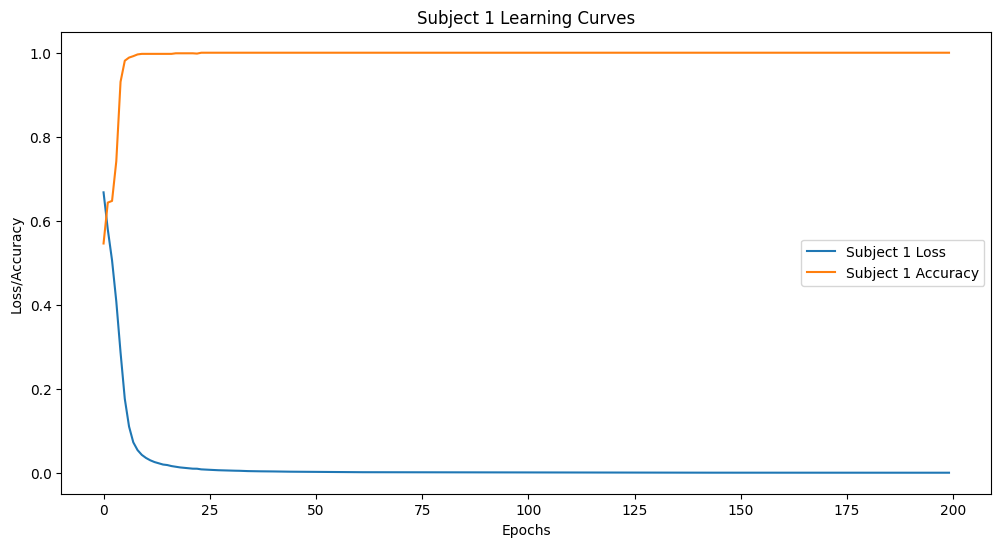

In [122]:
plt.figure(figsize=(12, 6))
plt.plot(train_losses1, label='Subject 1 Loss')
plt.plot(train_accuracies1, label='Subject 1 Accuracy')
plt.title('Subject 1 Learning Curves')
plt.xlabel('Epochs')
plt.ylabel('Loss/Accuracy')
plt.legend()
plt.show()

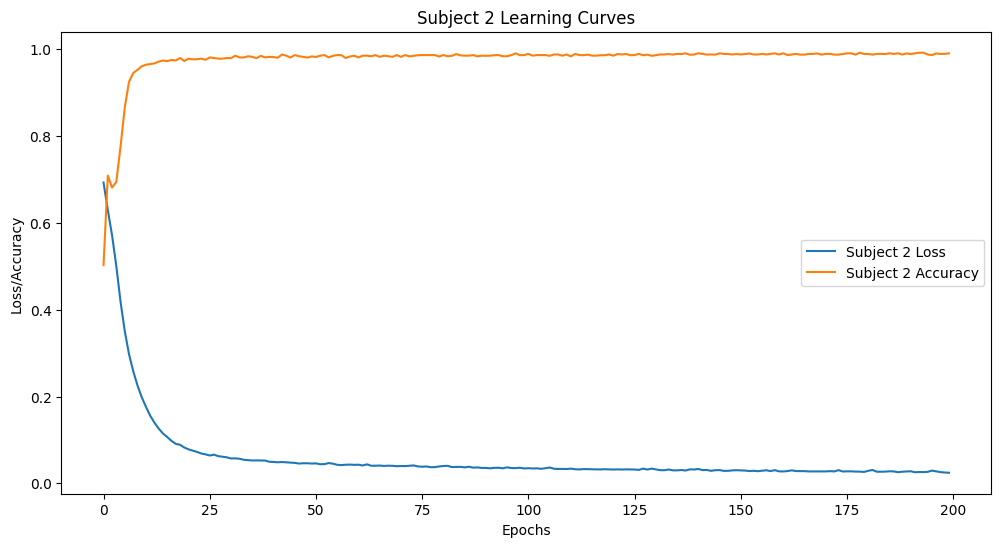

In [123]:
plt.figure(figsize=(12, 6))
plt.plot(train_losses2, label='Subject 2 Loss')
plt.plot(train_accuracies2, label='Subject 2 Accuracy')
plt.title('Subject 2 Learning Curves')
plt.xlabel('Epochs')
plt.ylabel('Loss/Accuracy')
plt.legend()
plt.show()

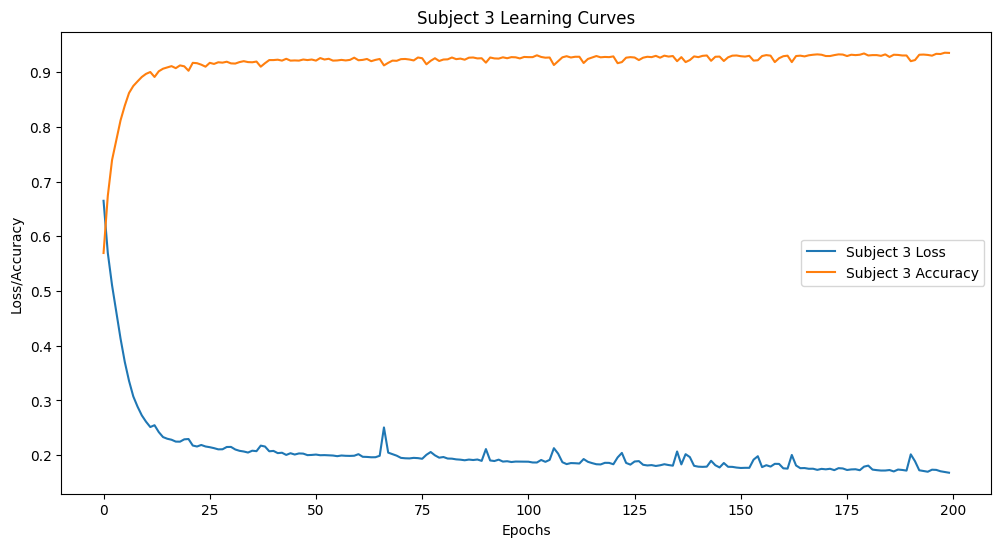

In [124]:
plt.figure(figsize=(12, 6))
plt.plot(train_losses3, label='Subject 3 Loss')
plt.plot(train_accuracies3, label='Subject 3 Accuracy')
plt.title('Subject 3 Learning Curves')
plt.xlabel('Epochs')
plt.ylabel('Loss/Accuracy')
plt.legend()
plt.show()

## Evaluate the Models

In [125]:
from sklearn.metrics import confusion_matrix

model1.eval()
all_predictions1 = []
all_labels1 = []
with torch.no_grad():
    for inputs, label in subject1_test_loader:
        output = model1(inputs)
        _, predicted = torch.max(output.data, 1)
        all_predictions1.extend(predicted.cpu().numpy())
        all_labels1.extend(label.cpu().numpy())

# create confusion matrix
cm1 = confusion_matrix(all_labels1, all_predictions1)
print("Confusion Matrix for Subject 1:")
print(cm1)

Confusion Matrix for Subject 1:
[[ 70   0]
 [  0 112]]


In [126]:
model2.eval()
all_predictions2 = []
all_labels2 = []
with torch.no_grad():
    for inputs, label in subject2_test_loader:
        output = model2(inputs)
        _, predicted = torch.max(output.data, 1)
        all_predictions2.extend(predicted.cpu().numpy())
        all_labels2.extend(label.cpu().numpy())

# create confusion matrix
cm2 = confusion_matrix(all_labels2, all_predictions2)
print("Confusion Matrix for Subject 2:")
print(cm2)

Confusion Matrix for Subject 2:
[[ 61   0]
 [  2 120]]


In [127]:
model3.eval()
all_predictions3 = []
all_labels3 = []
with torch.no_grad():
    for inputs, label in subject3_test_loader:
        output = model3(inputs)
        _, predicted = torch.max(output.data, 1)
        all_predictions3.extend(predicted.cpu().numpy())
        all_labels3.extend(label.cpu().numpy())

# create confusion matrix
cm3 = confusion_matrix(all_labels3, all_predictions3)
print("Confusion Matrix for Subject 3:")
print(cm3)

Confusion Matrix for Subject 3:
[[210  43]
 [ 36 448]]


# Reflection

I had issues analyzing the PSDs for oscillating bands. At first, I was getting about 50 peaks for NREM and 2 peaks for WAKE. I changed the input parameters for find_peaks, and that lowered it to 20 peaks for NREM and 2 for WAKE. However, I could not have an unequal amount of peaks, as that would result in non-uniform input vectors. I noticed that the the NREM bands consisted of the WAKE bands, so I chose to go with the WAKE bands. Additionally, my input features were not a flattened (1-D) vector, so I had to figure out how to flatten those.

Aside from those issues, the project went pretty smoothly. I randomly chose a network architecture and hyperparameters, and they worked pretty well. I could split off a validation set to optimize those, but I think that would take too much time for not enough return.

Additionally, I decided that evaluating the models on accuracy alone was not enough. So I modified the evaluation process to instead fill a confusion matrix rather than only calculating the accuracy.

Since model 3 consists of more data samples, I think it has a higher chance of over-fitting. I think it would perform better with hyperparameters different than those for model 1 and model 1. However, I wanted to keep all models consistent in their architecture/training.